In [1]:
!pip3 install datasets
!pip3 install transformers
!pip3 install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from datasets import list_datasets, load_dataset
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, DistilBertTokenizer, AutoModel, AutoModelForSequenceClassification, Trainer, TrainingArguments, pipeline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score, f1_score
from umap import UMAP

In [3]:
from huggingface_hub import notebook_login

In [4]:
notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.huggingface/token
Login successful


In [5]:
all_datasets = list_datasets()
print(f"There are {len(all_datasets)} datasets currently available on the Hub")
print(f"The first 10 are: {all_datasets[:10]}")

There are 16364 datasets currently available on the Hub
The first 10 are: ['acronym_identification', 'ade_corpus_v2', 'adversarial_qa', 'aeslc', 'afrikaans_ner_corpus', 'ag_news', 'ai2_arc', 'air_dialogue', 'ajgt_twitter_ar', 'allegro_reviews']


In [6]:
emotions = load_dataset("SetFit/emotion")

  0%|          | 0/3 [00:00<?, ?it/s]

In [7]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 16000
    })
    test: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 2000
    })
    validation: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 2000
    })
})

In [8]:
train_ds = emotions["train"]
train_ds

Dataset({
    features: ['text', 'label', 'label_text'],
    num_rows: 16000
})

In [9]:
print(train_ds[0])
print(train_ds.column_names)
print(train_ds.features)

{'text': 'i didnt feel humiliated', 'label': 0, 'label_text': 'sadness'}
['text', 'label', 'label_text']
{'text': Value(dtype='string', id=None), 'label': Value(dtype='int64', id=None), 'label_text': Value(dtype='string', id=None)}


In [10]:
emotions.set_format(type="pandas")
df = emotions["train"][:]
df.head()

,text,label,label_text
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


In [12]:
# def label_int2str(row):
#   return emotions["train"].features["label"].int2str(row)

# df["label_name"] = df["label"].apply(label_int2str)
# df.head()

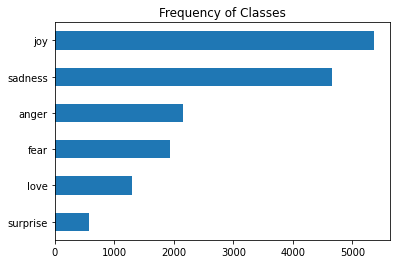

In [13]:
df["label_text"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


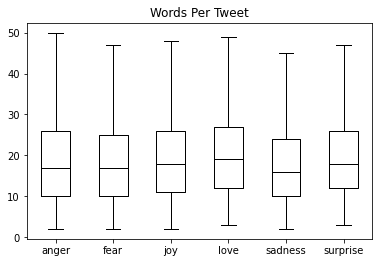

In [14]:
df["Words Per Tweet"] = df["text"].str.split().apply(len)
df.boxplot("Words Per Tweet", by="label_text", grid=False, showfliers=False, color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

In [15]:
emotions.reset_format()

Character Tokenization

In [16]:
text = "Tokenizing text is a core task of NLP."
tokenized_text = list(text)
print(tokenized_text)

['T', 'o', 'k', 'e', 'n', 'i', 'z', 'i', 'n', 'g', ' ', 't', 'e', 'x', 't', ' ', 'i', 's', ' ', 'a', ' ', 'c', 'o', 'r', 'e', ' ', 't', 'a', 's', 'k', ' ', 'o', 'f', ' ', 'N', 'L', 'P', '.']


In [17]:
token2idx = {ch:idx for idx, ch in enumerate(sorted(set(tokenized_text)))}
print(token2idx)
print(len(token2idx))

{' ': 0, '.': 1, 'L': 2, 'N': 3, 'P': 4, 'T': 5, 'a': 6, 'c': 7, 'e': 8, 'f': 9, 'g': 10, 'i': 11, 'k': 12, 'n': 13, 'o': 14, 'r': 15, 's': 16, 't': 17, 'x': 18, 'z': 19}
20


In [18]:
input_ids = [token2idx[token] for token in tokenized_text]
print(input_ids)
print(len(input_ids))

[5, 14, 12, 8, 13, 11, 19, 11, 13, 10, 0, 17, 8, 18, 17, 0, 11, 16, 0, 6, 0, 7, 14, 15, 8, 0, 17, 6, 16, 12, 0, 14, 9, 0, 3, 2, 4, 1]
38


In [19]:
input_ids = torch.tensor(input_ids)
one_hot_encodings = F.one_hot(input_ids, num_classes=len(token2idx))
one_hot_encodings.shape

torch.Size([38, 20])

In [20]:
print(f"Token: {tokenized_text[0]}")
print(f"Tensor index: {input_ids[0]}")
print(f"One-hot: {one_hot_encodings[0]}")

Token: T
Tensor index: 5
One-hot: tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


Word Tokenization

In [21]:
tokenized_text = text.split()
print(tokenized_text)

['Tokenizing', 'text', 'is', 'a', 'core', 'task', 'of', 'NLP.']


Subword Tokenization

In [22]:
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [23]:
distilbert_tokenizer = DistilBertTokenizer.from_pretrained(model_ckpt)

In [24]:
encoded_text = tokenizer(text)
print(encoded_text)

{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953, 2361, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [25]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['[CLS]', 'token', '##izing', 'text', 'is', 'a', 'core', 'task', 'of', 'nl', '##p', '.', '[SEP]']


In [26]:
print(tokenizer.convert_tokens_to_string(tokens))

[CLS] tokenizing text is a core task of nlp. [SEP]


In [27]:
print(tokenizer.vocab_size)
print(tokenizer.model_max_length)
print(tokenizer.model_input_names)

30522
512
['input_ids', 'attention_mask']


Tokenizing the Whole Dataset

In [28]:
def tokenize(batch):
  return tokenizer(batch["text"], padding=True, truncation=True)

In [29]:
print(emotions["train"][:2])
print(tokenize(emotions["train"][:2]))

{'text': ['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake'], 'label': [0, 0], 'label_text': ['sadness', 'sadness']}
{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [30]:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

In [31]:
print(emotions_encoded["train"].column_names)

['text', 'label', 'label_text', 'input_ids', 'attention_mask']


In [32]:
model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [33]:
text = "this is a test"
inputs = tokenizer(text, return_tensors="pt")
print(f"Input tensor shape: {inputs['input_ids'].size()}")

Input tensor shape: torch.Size([1, 6])


In [34]:
inputs.items()

dict_items([('input_ids', tensor([[ 101, 2023, 2003, 1037, 3231,  102]])), ('attention_mask', tensor([[1, 1, 1, 1, 1, 1]]))])

In [35]:
inputs = {k:v.to(device) for k, v in inputs.items()}  # use items() to use both key and value of dictionary while for function
with torch.no_grad():
  outputs = model(**inputs)
print(outputs)

BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ..., -0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]],
       device='cuda:0'), hidden_states=None, attentions=None)


In [36]:
outputs.last_hidden_state.size()  #[batch_size, n_tokens, hidden_dim]

torch.Size([1, 6, 768])

In [37]:
outputs.last_hidden_state[:, 0].size()

torch.Size([1, 768])

In [38]:
def extract_hidden_states(batch):
  inputs = {k:v.to(device) for k, v in batch.items() if k in tokenizer.model_input_names}

  with torch.no_grad():
    last_hidden_state = model(**inputs).last_hidden_state
  return {"hidden_state": last_hidden_state[:, 0].cpu().numpy()}

In [39]:
emotions_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])

In [40]:
emtions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)

In [41]:
emtions_hidden["train"].column_names

['text', 'label', 'label_text', 'input_ids', 'attention_mask', 'hidden_state']

In [42]:
x_train = np.array(emtions_hidden["train"]["hidden_state"])
x_valid = np.array(emtions_hidden["validation"]["hidden_state"])
y_train = np.array(emtions_hidden["train"]["label"])
y_valid = np.array(emtions_hidden["validation"]["label"])
x_train.shape, x_valid.shape

((16000, 768), (2000, 768))

In [43]:
x_scaled = MinMaxScaler().fit_transform(x_train)
mapper = UMAP(n_components=2, metric="cosine").fit(x_scaled)
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb.head()

,X,Y
0,4.603818,6.514864
1,-2.642968,6.129497
2,5.226764,3.086188
3,-2.262128,3.627568
4,-3.217738,3.948945


In [44]:
list(set(emotions["train"]["label_text"]))
list(set(emotions["train"]["label"]))

[0, 1, 2, 3, 4, 5]

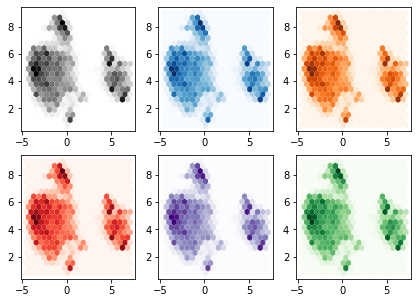

In [45]:
fig, axes = plt.subplots(2, 3, figsize=(7, 5))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
labels = list(set(emotions["train"]["label_text"])) # label, label_text
for i, (label, cmap) in enumerate(zip(labels, cmaps)):
  # df_emb_sub = df_emb.query(f"label=={i}")
  df_emb_sub = df_emb
  axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap, gridsize=20, linewidths=(0, ))

Training a simple classifier

In [46]:
lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(x_train, y_train)
lr_clf.score(x_valid, y_valid)

0.633

In [47]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(x_train, y_train)
dummy_clf.score(x_valid, y_valid)

0.352

In [48]:
def plot_confusion_matrix(y_preds, y_true, labels):
  cm = confusion_matrix(y_true, y_preds, normalize="true")
  fig, ax = plt.subplots(figsize=(6, 6))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
  plt.title("Normalized confusion matrix")
  plt.show()

Fine-Tuning Transformers

In [49]:
num_labels = 6
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels).to(device)
# AutoModelForSequenceClassification has classification head on top of the pretrained model outputs

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.bias', 'pre_classifi

In [50]:
def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  f1 = f1_score(labels, preds, average="weighted")
  acc = accuracy_score(labels, preds)
  return {"accuracy": acc, "f1": f1}

In [51]:
batch_size =64
logging_steps = len(emotions_encoded["train"])
model_name = f"{model_ckpt}-finetuned-emotion"
training_args = TrainingArguments(output_dir = model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=True,
                                  log_level="error")

In [52]:
trainer = Trainer(model=model,
                  args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=emotions_encoded["train"],
                  eval_dataset=emotions_encoded["validation"],
                  tokenizer=tokenizer)

/usr/local/lib/python3.8/dist-packages/huggingface_hub/repository.py:725: FutureWarning: Creating a repository through 'clone_from' is deprecated and will be removed in v0.12. Please create the repository first using `create_repo(..., exists_ok=True)`.
  warnings.warn(
Cloning https://huggingface.co/ryusangwon/distilbert-base-uncased-finetuned-emotion into local empty directory.


In [53]:
trainer.train()

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.327110,0.903000,0.898286
2,No log,0.225439,0.925000,0.924880


TrainOutput(global_step=500, training_loss=0.5457767333984375, metrics={'train_runtime': 240.402, 'train_samples_per_second': 133.11, 'train_steps_per_second': 2.08, 'total_flos': 720342861696000.0, 'train_loss': 0.5457767333984375, 'epoch': 2.0})

In [54]:
preds_output = trainer.predict(emotions_encoded["validation"])

In [55]:
preds_output.metrics

{'test_loss': 0.22543922066688538,
 'test_accuracy': 0.925,
 'test_f1': 0.9248800675460169,
 'test_runtime': 4.2859,
 'test_samples_per_second': 466.642,
 'test_steps_per_second': 7.466}

In [56]:
y_preds = np.argmax(preds_output.predictions, axis=1)

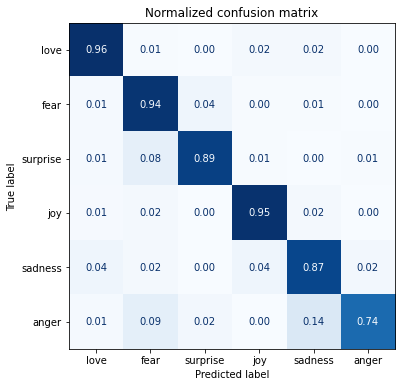

In [57]:
plot_confusion_matrix(y_preds, y_valid, labels)

In [58]:
tokenizer.model_input_names

['input_ids', 'attention_mask']

In [59]:
def forward_pass_with_label(batch):
  inputs = {k:v.to(device) for k, v in batch.items() if k in tokenizer.model_input_names}
  with torch.no_grad():
    output = model(**inputs)
    pred_label = torch.argmax(output.logits, axis=1)
    loss = F.cross_entropy(output.logits, batch["label"].to(device), reduction="none")
  
  return {"loss": loss.cpu().numpy(), "predicted_label": pred_label.cpu().numpy()}

In [60]:
emotions_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label", "label_text"])

emotions_encoded["validation"] = emotions_encoded["validation"].map(forward_pass_with_label, batched=True, batch_size=16)

  0%|          | 0/125 [00:00<?, ?ba/s]

In [61]:
emotions_encoded["validation"][:5]

{'label': tensor([0, 0, 2, 3, 1]),
 'label_text': ['sadness', 'sadness', 'love', 'anger', 'joy'],
 'input_ids': tensor([[  101, 10047,  3110,  3243,  6517,  1998,  3374,  2005,  2870,  2021,
           5665, 10245,  2041,  1997,  2009,  2574,   102,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0],
         [  101,  1045,  2514,  2066,  1045,  2572,  2145,  2559,  2012,  1037,
           8744, 10683,  8744,  4109,  1997,  3259,   102,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0

In [62]:
emotions_encoded.set_format("pandas")
cols = ["text", "label", "label_text", "predicted_label", "loss"]
df_test = emotions_encoded["validation"][:][cols]
df_test["label"] = df_test["label_text"]
# df_test["predicted_label"] = (df_test["predicted_label"].apply(label_int2str))

In [63]:
df_test.sort_values("loss", ascending=False).head(10)

,text,label,label_text,predicted_label,loss
1274,i am going to several holiday parties and i ca...,joy,joy,0,5.229615
1963,i called myself pro life and voted for perry w...,joy,joy,0,5.085646
465,i would eventually go in to these stores but i...,joy,joy,4,4.989234
1950,i as representative of everything thats wrong ...,surprise,surprise,0,4.926706
765,i feel super awkward and out of place right now,joy,joy,0,4.869958
318,i felt ashamed of these feelings and was scare...,fear,fear,0,4.804810
1509,i guess this is a memoir so it feels like that...,joy,joy,4,4.793710
1683,i had applied for a job and they had assured m...,anger,anger,1,4.717098
882,i feel badly about reneging on my commitment t...,love,love,0,4.662333
1500,i guess we would naturally feel a sense of lon...,anger,anger,0,4.634847


In [64]:
df_test.sort_values("loss", ascending=True).head(10)

,text,label,label_text,predicted_label,loss
133,i and feel quite ungrateful for it but i m loo...,sadness,sadness,0,0.019481
1310,i feel like an ungrateful asshole,sadness,sadness,0,0.019528
1502,i feel ungrateful for stupid shit like,sadness,sadness,0,0.019577
1601,i feel so ungrateful when thinking saying thes...,sadness,sadness,0,0.019915
1226,im feeling terrific and in great shape im opti...,joy,joy,1,0.019958
199,i feel invigorated full of energy ready for th...,joy,joy,1,0.020042
1466,i feel so ungrateful to be wishing this pregna...,sadness,sadness,0,0.020048
21,i feel try to tell me im ungrateful tell me im...,sadness,sadness,0,0.020101
1675,i know i cannot rest of my laurels and its a a...,joy,joy,1,0.020470
1152,i feel pathetic because i shouldn t complain a...,sadness,sadness,0,0.020476


In [65]:
trainer.push_to_hub(commit_message="Training completed")

Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file pytorch_model.bin:   0%|          | 3.30k/255M [00:00<?, ?B/s]

Upload file runs/Dec18_10-20-35_49bd83b211a5/events.out.tfevents.1671358844.49bd83b211a5.1276.0:  67%|######7 …

remote: Scanning LFS files for validity, may be slow...        
remote: LFS file scan complete.        
To https://huggingface.co/ryusangwon/distilbert-base-uncased-finetuned-emotion
   a298147..7a15676  main -> main

remote: LFS file scan complete.        
To https://huggingface.co/ryusangwon/distilbert-base-uncased-finetuned-emotion
   a298147..7a15676  main -> main

To https://huggingface.co/ryusangwon/distilbert-base-uncased-finetuned-emotion
   7a15676..ae8d8d8  main -> main

   7a15676..ae8d8d8  main -> main



'https://huggingface.co/ryusangwon/distilbert-base-uncased-finetuned-emotion/commit/7a15676ffdcf3158778838c777fb4e533d9970e5'

In [66]:
model_id = "ryusangwon/distilbert-base-uncased-finetuned-emotion"
classifier = pipeline("text-classification", model=model_id)

Downloading:   0%|          | 0.00/883 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/360 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/711k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [67]:
custom_tweet = "I saw a movie today and it was really good"
preds = classifier(custom_tweet, return_all_scores=True)

/usr/local/lib/python3.8/dist-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar funcionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


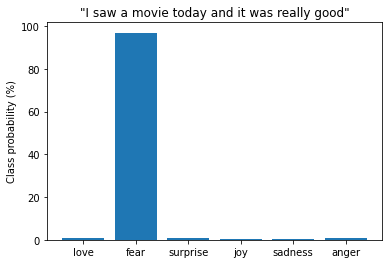

In [68]:
preds_df = pd.DataFrame(preds[0])
plt.bar(labels, 100 * preds_df["score"], color="C0")
plt.title(f'"{custom_tweet}"')
plt.ylabel("Class probability (%)")
plt.show()